In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
tf.config.run_functions_eagerly(True)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #esta linea salva vidas
tf.config.experimental_run_functions_eagerly(False)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [3]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Miguel/Desktop/Fotos para IA/Reptiles/Imagenes_entreno_2k',
    labels='inferred',
    label_mode="categorical",#probar a poner categorical(one_hot automatico)
    class_names=['Cocodrilo', 'Lagartos', 'Serpientes', 'Tortuga'],
    color_mode='rgb',
    batch_size=None, #Se especificara mas adelante
    image_size=(150,150), #Redimension de imagenes
    shuffle=True,  #Baraja las imagenes
    seed=123,#Semilla estatica
    validation_split=0.15,
    subset="training",


)

Found 9429 files belonging to 4 classes.
Using 8015 files for training.


In [4]:
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Miguel/Desktop/Fotos para IA/Reptiles/Imagenes_entreno_2k',
    labels='inferred',
    label_mode="categorical",
    class_names=['Cocodrilo', 'Lagartos', 'Serpientes', 'Tortuga'],
    color_mode='rgb',
    batch_size=None, #Se especificara mas adelante
    image_size=(150,150), #Para redimensionar las imagenes
    shuffle=True,  #Baraja las imagenes
    seed=123,#Semilla estatica
    validation_split=0.15,
    subset="validation",


)

Found 9429 files belonging to 4 classes.
Using 1414 files for validation.


In [5]:
#IMAGENES Y LABELS TRAIN
X=[]
Y=[]
for i,(img,label) in enumerate(ds_train):
  #img=cv2.resize(img.numpy(),(tamano_img, tamano_img)) ya hemmos redimensionado
  #img=img.reshape(tamano_img, tamano_img,3)
  X.append(img/255)#dividimos entre 255 para normalizar o se va todo a la mierda
  Y.append(label)

In [6]:
#IMAGENES Y LABELS TEST
Xtest=[]
Ytest=[]
for i,(img,label) in enumerate(ds_validation):
  #img=cv2.resize(img.numpy(),(tamano_img, tamano_img)) ya hemmos redimensionado
  #img=img.reshape(tamano_img, tamano_img,3)
  Xtest.append(img/255)#dividimos entre 255 para normalizar o se va todo a la mierda
  Ytest.append(label)

In [ ]:
#FUNCION PARA COMPROBAR SI LAS IMAGENES SON COMPATIBLES CON TENSORFLOW
from pathlib import Path
import imghdr
contador=0
data_dir = "C:/Users/Miguel/Desktop/Fotos para IA/Reptiles/Imagenes_entreno_2k"
image_extensions = [".png", ".jpg",".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            contador+=1
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            contador+=1
print(f"Numero de fotos: {contador}")

In [7]:
X=np.array(X)
Xtest=np.array(Xtest)
X[0]
Y=np.array(Y)
Ytest=np.array(Ytest)


In [ ]:
#USAMOS CODIFICACION ONE HOT NECESARIO SI NO HEMOS PUESTO label_mode="categorical"
Y = tf.keras.utils.to_categorical(Y, num_classes=5)
Ytest = tf.keras.utils.to_categorical(Ytest, num_classes=5)

In [ ]:
#PEQUEÑAS COMPROBACIONES
print(Y.shape)
print(X.shape)

In [ ]:
#IMPRIMIMOS UNOS EJEMPLOS DEL TRAIN
plt.figure(figsize=(35,35))
for i in range (4):
  plt.subplot(2,2,i+1)
  plt.yticks([])
  plt.xticks([])
  plt.title(f'Label: {Y[i]}')  # Mostrar el label como título
  plt.imshow(X[i])

In [ ]:
#IMPRIMIMOS UNOS EJEMPLOS DEL TEST
for i in range (16):
  plt.subplot(4,4,i+1)
  plt.yticks([])
  plt.xticks([])
  plt.title(f'Label: {Ytest[i]}')  # Mostrar el label como título
  plt.imshow(Xtest[i])

# AUMENTO DE DATOS

In [8]:
#CREAMOS NUESTRO MODIFICADOR DE IMAGENES
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.01, #ojito con el shear range
    zoom_range=[0.6,1.2],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2]



)
data_gen_entrenamiento=datagen.flow(X,Y,batch_size=32)
data_gen_test=datagen.flow(Xtest,Ytest,batch_size=32)
#Le pasamos las imagenes y labels de entrenamiento
#Si algo falla aseurarse de tener las listas como np.array

# MODELO 1

In [ ]:
#CREAMOS NUESTRO MODELO
def crear_modelo():
  model=tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(120 ,120,3),padding='same'))
  #Conv2D(numero de filtros,(dimension de la matriz),activacion etc)
  #usamos el padding para no perder info de los bordes
  model.add(tf.keras.layers.MaxPool2D(2,2))
  #MaxPool reducira la dimension de la imagen(la hara mas pequeña),reduce el ruido
  model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(tf.keras.layers.MaxPool2D(2,2))

  model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(tf.keras.layers.MaxPool2D(2,2))

  #model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'))
  #model.add(tf.keras.layers.MaxPool2D(2,2))

  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100,activation='relu'))
  model.add(tf.keras.layers.Dense(4,activation='softmax'))
  return model

In [ ]:
model = crear_modelo()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics="accuracy")

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/modelo.4')
model.fit(
    data_gen_entrenamiento,
    epochs=20,batch_size=32,
    validation_data=data_gen_test,
    steps_per_epoch=int(np.ceil(len(X)/float(32))),
    #steps_per_epoch = total_samples / batch_size
    validation_steps=int(np.ceil(len(Xtest)/float(32))),
    #validation_steps = np.ceil(numero_total_muestras_validacion / tamano_lote_validacion).astype(int)
    callbacks=[tensorboard]
)

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/modelo.4')
model.fit(
    data_gen_entrenamiento,
    epochs=50,batch_size=32,
    validation_data=(Xtest,Ytest),
    steps_per_epoch=int(np.ceil(len(X)/float(32))),
    #steps_per_epoch = total_samples / batch_size
    validation_steps=int(np.ceil(len(Xtest)/float(32))),
    #validation_steps = np.ceil(numero_total_muestras_validacion / tamano_lote_validacion).astype(int)
    callbacks=[tensorboard]
)

In [ ]:
predicciones = model.predict(X)

# Imprimir las primeras 5 predicciones
print("Predicciones:")
print(predicciones[:5])

In [ ]:
%load_ext tensorboard

# Lanzamiento de TensorBoard
%tensorboard --logdir logs/modelo.10

In [ ]:
#HACEMOS UN TEST
test_loss = model.evaluate(Xtest, Ytest)
print(f"Test loss is: {test_loss}")

# MODELO 2 (TRANSFER LEARNING + FINE TUNING)

In [ ]:
#TRANSFER LEARNING
#usamos ResNet50 que tiene 50 capas y esta entrenada con imageNet

base_model=tf.keras.applications.resnet50.ResNet50(
    include_top=False,#para que elimina las capas flatten finales
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
)
#congelamos capas
for layer in base_model.layers[:-2]:
    layer.trainable=False


In [ ]:
#conexion para transfer learning
#nos enganchamos a la ultima capa
x = base_model.layers[-2].output
#añadimos capas para fine tuning
x = tf.keras.layers.Flatten(name='cflatten')(x)

x = tf.keras.layers.Dense(128,activation='relu',name='cD1')(x)
#x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(128,activation='relu',name='cD2')(x)
#x = tf.keras.layers.Dropout(0.3)(x)

output= tf.keras.layers.Dense(4,activation='softmax',name='output')(x)
#ponemos la input layer del modelo y el resto con el fine tunning
new_model = tf.keras.models.Model(base_model.inputs, output)

In [ ]:
new_model.summary()

In [ ]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics="accuracy")

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/modelo.7')
new_model.fit(
    data_gen_entrenamiento,
    epochs=50,batch_size=16,
    validation_data=data_gen_test,
    steps_per_epoch=int(np.ceil(len(X)/float(32))),
    #steps_per_epoch = total_samples / batch_size
    validation_steps=int(np.ceil(len(Xtest)/float(32))),
    #validation_steps = np.ceil(numero_total_muestras_validacion / tamano_lote_validacion).astype(int)
    callbacks=[tensorboard]
)

In [ ]:
%load_ext tensorboard

# Lanzamiento de TensorBoard
%tensorboard --logdir logs/modelo.7

# MODELO 3 (MOBILE NET)

In [ ]:
#TRANSFER LEARNING
#usamos ResNet50 que tiene 50 capas y esta entrenada con imageNet

base_model=tf.keras.applications.mobilenet.MobileNet(
    include_top=False,#para que elimina las capas flatten finales
    weights='imagenet',
    input_tensor=None,
    input_shape=(120,120,3),
)



In [ ]:
#conexion para transfer learning
#nos enganchamos a la ultima capa
x = base_model.layers[-1].output
#añadimos capas para fine tuning
x = tf.keras.layers.Flatten(name='cflatten')(x)

x = tf.keras.layers.Dense(128,activation='relu',name='cD1')(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(128,activation='relu',name='cD2')(x)
x = tf.keras.layers.Dropout(0.3)(x)

output= tf.keras.layers.Dense(4,activation='softmax',name='output')(x)
#ponemos la input layer del modelo y el resto con el fine tunning
new_model = tf.keras.models.Model(base_model.inputs, output)

In [ ]:
new_model.summary()

In [ ]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics="accuracy")

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/modelo.5')
new_model.fit(
    data_gen_entrenamiento,
    epochs=20,batch_size=16,
    validation_data=data_gen_test,
    steps_per_epoch=int(np.ceil(len(X)/float(32))),
    #steps_per_epoch = total_samples / batch_size
    validation_steps=int(np.ceil(len(Xtest)/float(32))),
    #validation_steps = np.ceil(numero_total_muestras_validacion / tamano_lote_validacion).astype(int)
    callbacks=[tensorboard]
)

In [ ]:
%load_ext tensorboard

# Lanzamiento de TensorBoard
%tensorboard --logdir logs/modelo.5

# MODELO 4 (INCEPTIONV3)

In [18]:
new_model= tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,#para que elimina las capas flatten finales
    weights='imagenet',
    input_tensor=None,
    input_shape=(150,150,3),
    
)
for layer in new_model.layers:
  layer.trainable = False

In [19]:
# Choose `mixed7` as the last layer of your base model
last_layer = new_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [26]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (4, activation='softmax')(x)

# Append the dense network to the base model
model = tf.keras.models.Model(new_model.inputs, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [27]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [28]:
history = model.fit(
            data_gen_entrenamiento,
            steps_per_epoch=int(np.ceil(len(X)/float(32))),
            epochs = 20,
            validation_data=data_gen_test,
            validation_steps=int(np.ceil(len(Xtest)/float(32))),
            verbose = 2)

Epoch 1/20
251/251 - 58s - loss: 2.3970 - accuracy: 0.2752 - val_loss: 1.7719 - val_accuracy: 0.2362 - 58s/epoch - 230ms/step
Epoch 2/20
251/251 - 53s - loss: 1.4983 - accuracy: 0.2780 - val_loss: 1.4463 - val_accuracy: 0.2744 - 53s/epoch - 210ms/step
Epoch 3/20
251/251 - 52s - loss: 1.4375 - accuracy: 0.2741 - val_loss: 1.3757 - val_accuracy: 0.2737 - 52s/epoch - 208ms/step
Epoch 4/20
251/251 - 52s - loss: 1.4095 - accuracy: 0.2765 - val_loss: 1.3665 - val_accuracy: 0.2694 - 52s/epoch - 207ms/step
Epoch 5/20
251/251 - 52s - loss: 1.3970 - accuracy: 0.2732 - val_loss: 1.5028 - val_accuracy: 0.2383 - 52s/epoch - 208ms/step
Epoch 6/20
251/251 - 52s - loss: 1.3835 - accuracy: 0.2681 - val_loss: 1.3668 - val_accuracy: 0.2673 - 52s/epoch - 208ms/step
Epoch 7/20
251/251 - 52s - loss: 1.3916 - accuracy: 0.2744 - val_loss: 1.3620 - val_accuracy: 0.2765 - 52s/epoch - 208ms/step
Epoch 8/20
251/251 - 52s - loss: 1.3827 - accuracy: 0.2787 - val_loss: 1.3728 - val_accuracy: 0.2977 - 52s/epoch - 208

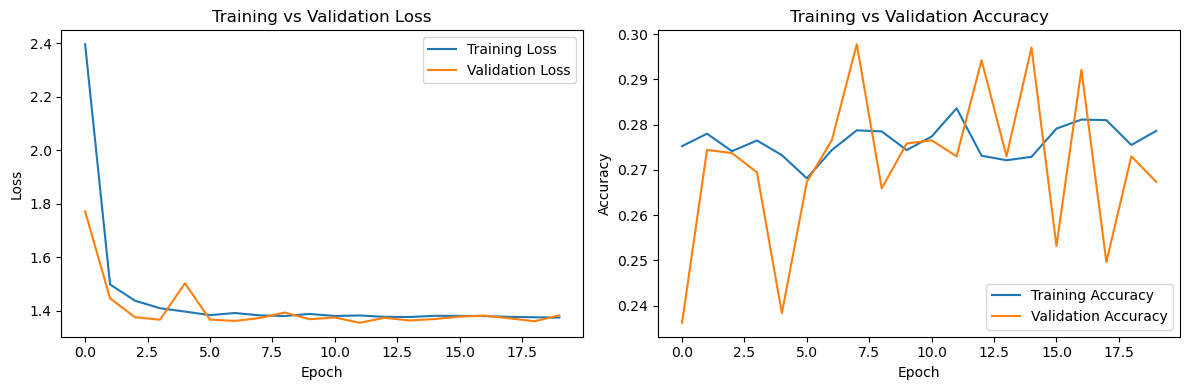

In [29]:
# Extraer la información de la pérdida y la precisión de los historiales
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Graficar la pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Graficar la precisión durante el entrenamiento y la validación
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Ajustar el diseño de los gráficos y mostrarlos
plt.tight_layout()
plt.show()